In [1]:
from myutils.nerdssData import Reaction_Name, _Reaction_nerdss, Write_Inp, Write_CrdInp
from myutils import utils
import numpy as np
from pathlib import Path

In [2]:
def notInNucleosomes(crd, nucCrds, nucSizes):
    for i in range(len(nucCrds)):
        if abs(crd - nucCrds[i]) <= nucSizes[i]:
            return False
    return True

def generate_N_crd(N_nonspec, xlim):
    NCrds = np.random.rand(N_nonspec)*(xlim[1]-xlim[0])+xlim[0]
    return NCrds

def generate_P_crd(Np, xlim, y, z, sigma):
    aveDistance = (xlim[1]-xlim[0])/(Np+1)
    pCrds = []
    for i in range(Np):
        if i%2 == 0:
            pCrds.append([ xlim[0] + (i+1)*aveDistance, y, z])
        else:
            pCrds.append([ xlim[0] + (i-1+1)*aveDistance+sigma, y, z])
                
    return pCrds

# for comparing two segments

## dimers

In [3]:
def onRate_macro2micro(ka_macro, D, sigma):
        if ka_macro < 1e-10:
            return 0
        else:
            return (1/ka_macro - 1/(4*np.pi*D*sigma))**-1

def get_static_Parms(
    kbPFixed=0.4, DP3D=1.5, DN1D=1.0, PPsigma=1.4, 
    lengthScale=50, dt=1, area3Dto1D=10, 
    kaPS_macro = 1000, kaPN_macro = 200
):
    
    C0 = 0.6022

    DP1D = (1/DP3D + 1/DN1D)**(-1)
    konMax = (4*np.pi*(2*DP3D)*PPsigma)
    print('DP1D: %.3f\tKonD3d: %.3f\tKPPmax (M^-1): %.1e'%(DP1D, konMax, konMax/(kbPFixed*1e-6)*C0))
    kaPS = onRate_macro2micro(kaPS_macro*1e-6, DP3D, 1)
    kaPN = onRate_macro2micro(kaPN_macro*1e-6, DP3D, 1)

    Rmax = PPsigma + 3 * np.sqrt( 6*DP3D*2 * dt )
    
    passed = True
    if Rmax > WaterBox[0]/2:
        print(f'Diffusion per step too large to stay in waterbox.x: Rmax={Rmax:.1f}, x/2={WaterBox[0]/2:.1f}')
        passed = True
    if Rmax > WaterBox[1]/2:
        print(f'Diffusion per step too large to stay in waterbox.y: Rmax={Rmax:.1f}, x/2={WaterBox[1]/2:.1f}')
        passed = True
    if Rmax > WaterBox[2]/2:
        print(f'Diffusion per step too large to stay in waterbox.z: Rmax={Rmax:.1f}, x/2={WaterBox[2]/2:.1f}')
        passed = True
    if passed:
        print('Diffusion and time step fit in waterbox.')
        
    L = lengthScale*21/2 - PPsigma # nm
    Diff = DP1D* 2 # nm^2/us
    onRateDiff = (L/3/Diff)**(-1)
    print(f'(L/(3D))^(-1) = {onRateDiff:.1e} nm/us')
    
    return kaPS, kaPN

In [4]:
lengthScale = 2
WaterBox = [21*lengthScale*2 + 22, 31.623, 31.623]
excLength = 5.51
kbPFixed = 0.4
ppSigma = 1.4
DP3D = 1.5

# manualy set the positions of targets
quarter = WaterBox[0]/4
SCrds_CB = [-quarter-1, -quarter+1, int(2*quarter*2/3)/2, int(2*quarter*4/3)/2]
# automatically calculate the N crds and nuc crds
N_non = int(12*lengthScale - len(SCrds_CB)/2)
NCrds = np.concatenate([
    generate_N_crd(N_non, [-WaterBox[0]/2+excLength, -excLength]), 
    generate_N_crd(N_non, [excLength, WaterBox[0]/2-excLength])
])
nucCrds = [-WaterBox[0]/2, WaterBox[0]/2, 0] 
print('Nuc:', nucCrds)
print('S:', SCrds_CB)
# calculate fixed parameters
kaPS, kaPN = get_static_Parms(
    kbPFixed, PPsigma=ppSigma, DP3D=DP3D, kaPN_macro=20000, kaPS_macro=100000
)

Nuc: [-53.0, 53.0, 0]
S: [-27.5, -25.5, 17.5, 35.0]
DP1D: 0.600	KonD3d: 52.779	KPPmax (M^-1): 7.9e+07
Diffusion and time step fit in waterbox.
(L/(3D))^(-1) = 6.9e-03 nm/us


In [5]:
C0 = 0.6022
def rlog(x, acc=2):
    if x==0:
        return '-inf'
    else:
        if acc==0:
            return int(np.log10(x))
        else:
            return round(np.log10(x), acc)

equi_parms = [
    [10/C0, 0/C0],
    [10/C0, 1e1/C0], #
    [10/C0, 1e2/C0], #
    [10/C0, 1e3/C0], #
    [10/C0, 1e4/C0], #
    [10/C0, 1e5/C0], #
    [10/C0, 1e6/C0], #
] # M^-1 -> nm^3

N_repeat = 48
accBind = 1 # accelarate binding to relax from bound state
pfolder = './twoSegments_4pro/'

for KPN, KPP in equi_parms:
    KPS = KPN*1e3
    kbPS = kaPS*1e6 / KPS
    kbPN = kaPN*1e6 / KPN
    if KPP == 0:
        kbPP = 0
        kaPP = 0
    else:
        kbPP = kbPFixed
        kaPP = onRate_macro2micro(KPP*kbPP*1e-6, 2*DP3D, ppSigma)
        kbPP = kaPP / KPP * 1e6
        
    print('kaP: %.2e'%kaPP, 'kbP: %.2e'%kbPP, 'kbN: %.2e'%kbPN, 'kbS: %.2e'%kbPS)
    nItr = 1001
    SCrds = SCrds_CB
    
    for rn in range(N_repeat):
        if KPP == 0:
            namedir = f'{pfolder}/kpp0kpnE{rlog(KPN*C0,1)}/{rn}/'
        else:
            namedir = f'{pfolder}/kppE{rlog(KPP*C0,1)}kpnE{rlog(KPN*C0,1)}/{rn}/'
        parmFile = f'''# two proteins discover between two segments

start parameters
    nItr = {int(nItr)} #iterations
    timeStep = 1 # us, the maximum timestep calculated from kbPN
    timeWrite = 1e5
    pdbWrite = 1e5
    trajWrite = {int((nItr/1e1))}
    assocdissocwrite = true
    overlapSepLimit = 1.0
end parameters

start boundaries
    WaterBox = {WaterBox} # VtoL=4000
end boundaries

start molecules
    P : 4
    N : {len(NCrds)}
    S : {len(SCrds)}
    nuc : {len(nucCrds)}
end molecules

start reactions

    N(ref) + nuc(ref) -> N(ref!1).nuc(ref!1)
    onRate3Dka = 0
    offRatekb = 0
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 5.5
    assocAngles = [nan, nan, nan, nan, nan]
    loopcoopfactor = 1
    bindRadSameCom = 1.1

    P(ref) + nuc(ref) -> P(ref!1).nuc(ref!1)
    onRate3Dka = 0
    offRatekb = 0
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 5.5
    assocAngles = [nan, nan, nan, nan, nan]
    loopcoopfactor = 1
    bindRadSameCom = 1.1    

    S(re1) + S(re2) -> S(re1!1).S(re2!1)
    onRate3Dka = 1e6
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.8001
    assocAngles = [M_PI, M_PI, nan, nan, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.00001

    S(bs) + P(dbs) <-> S(bs!1).P(dbs!1)
    onRate3Dka = {kaPS}
    offRatekb = {kbPS} # Keq = 10^{rlog(1e3*KPN*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.00
    assocAngles = [0.785398, 2.356194, 0.000000, M_PI, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10

    N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
    onRate3Dka = {kaPN}
    offRatekb = {kbPN} # Keq = 10^{rlog(KPN*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.000007
    assocAngles = [1.604246, 0.948003, 1.221389, -2.514197, -1.261396]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10
    
    P(pp1) + P(pp2) <-> P(pp1!1).P(pp2!1)
    onRate3Dka = {kaPP} 
    offRatekb = {kbPP} # Keq = 10^{rlog(KPP*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.4
    assocAngles = [2.111216, 2.111216, -1.570796, 1.570796, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10

end reactions
'''
        # create directory and write parameters
        Path(namedir).mkdir(parents=True, exist_ok=True)
        with open(f'./{namedir}/parms.inp', 'w') as f:
            f.write(parmFile)
        # write coordinates
        crdFileName = f'./{namedir}/fixCoordinates.inp'
        fixCoords={'S':SCrds,  'N':NCrds, 'nuc':nucCrds}
        Write_CrdInp(crdFileName, fixCoords, WaterBox)

kaP: 0.00e+00 kbP: 0.00e+00 kbN: 1.21e+03 kbS: 6.05e+00
kaP: 6.64e-06 kbP: 4.00e-01 kbN: 1.21e+03 kbS: 6.05e+00
kaP: 6.64e-05 kbP: 4.00e-01 kbN: 1.21e+03 kbS: 6.05e+00
kaP: 6.64e-04 kbP: 4.00e-01 kbN: 1.21e+03 kbS: 6.05e+00
kaP: 6.64e-03 kbP: 4.00e-01 kbN: 1.21e+03 kbS: 6.05e+00
kaP: 6.65e-02 kbP: 4.01e-01 kbN: 1.21e+03 kbS: 6.05e+00
kaP: 6.73e-01 kbP: 4.05e-01 kbN: 1.21e+03 kbS: 6.05e+00


## multimer in a row

In [17]:
def onRate_macro2micro(ka_macro, D, sigma):
        if ka_macro < 1e-10:
            return 0
        else:
            return (1/ka_macro - 1/(4*np.pi*D*sigma))**-1

def get_static_Parms(
    kbPFixed=0.4, DP3D=1.5, DN1D=1.0, PPsigma=1.4, 
    lengthScale=50, dt=1, area3Dto1D=10, 
    kaPS_macro = 1000, kaPN_macro = 200
):
    
    C0 = 0.6022

    DP1D = (1/DP3D + 1/DN1D)**(-1)
    konMax = (4*np.pi*(2*DP3D)*PPsigma)
    print('DP1D: %.3f\tKonD3d: %.3f\tKPPmax (M^-1): %.1e'%(DP1D, konMax, konMax/(kbPFixed*1e-6)*C0))
    kaPS = onRate_macro2micro(kaPS_macro*1e-6, DP3D, 1)
    kaPN = onRate_macro2micro(kaPN_macro*1e-6, DP3D, 1)

    Rmax = PPsigma + 3 * np.sqrt( 6*DP3D*2 * dt )
    
    passed = True
    if Rmax > WaterBox[0]/2:
        print(f'Diffusion per step too large to stay in waterbox.x: Rmax={Rmax:.1f}, x/2={WaterBox[0]/2:.1f}')
        passed = True
    if Rmax > WaterBox[1]/2:
        print(f'Diffusion per step too large to stay in waterbox.y: Rmax={Rmax:.1f}, x/2={WaterBox[1]/2:.1f}')
        passed = True
    if Rmax > WaterBox[2]/2:
        print(f'Diffusion per step too large to stay in waterbox.z: Rmax={Rmax:.1f}, x/2={WaterBox[2]/2:.1f}')
        passed = True
    if passed:
        print('Diffusion and time step fit in waterbox.')
        
    L = lengthScale*21/2 - PPsigma # nm
    Diff = DP1D* 2 # nm^2/us
    onRateDiff = (L/3/Diff)**(-1)
    print(f'(L/(3D))^(-1) = {onRateDiff:.1e} nm/us')
    
    return kaPS, kaPN

In [18]:
lengthScale = 3
WaterBox = [21*lengthScale*2 + 22, 31.623, 31.623]
excLength = 5.51
kbPFixed = 0.4
ppSigma = 1.4
DP3D = 1.5

# manualy set the positions of targets
quarter = WaterBox[0]/4
SCrds_CB = [-quarter-2, -quarter, -quarter+2, quarter/2, quarter, quarter*3/2]
# automatically calculate the N crds and nuc crds
N_non = int(12*lengthScale - len(SCrds_CB)/2)
NCrds = np.concatenate([
    generate_N_crd(N_non, [-WaterBox[0]/2+excLength, -excLength]), 
    generate_N_crd(N_non, [excLength, WaterBox[0]/2-excLength])
])
nucCrds = [-WaterBox[0]/2, WaterBox[0]/2, 0] 
print('Nuc:', nucCrds)
print('S:', SCrds_CB)
# calculate fixed parameters
kaPS, kaPN = get_static_Parms(
    kbPFixed, PPsigma=ppSigma, DP3D=DP3D, kaPN_macro=20000, kaPS_macro=100000
)

Nuc: [-74.0, 74.0, 0]
S: [-39.0, -37.0, -35.0, 18.5, 37.0, 55.5]
DP1D: 0.600	KonD3d: 52.779	KPPmax (M^-1): 7.9e+07
Diffusion and time step fit in waterbox.
(L/(3D))^(-1) = 6.9e-03 nm/us


In [19]:
C0 = 0.6022
def rlog(x, acc=2):
    if x==0:
        return '-inf'
    else:
        if acc==0:
            return int(np.log10(x))
        else:
            return round(np.log10(x), acc)

equi_parms = [
    [10/C0, 0/C0], #
    [10/C0, 1e6/C0], #
] # M^-1 -> nm^3

N_repeat = 15
accBind = 1 # accelarate binding to relax from bound state
pfolder = './twoSegments_trimer/'

for KPN, KPP in equi_parms:
    KPS = KPN*1e3
    kbPS = kaPS*1e6 / KPS
    kbPN = kaPN*1e6 / KPN
    if KPP == 0:
        kbPP = 0
        kaPP = 0
    else:
        kbPP = kbPFixed
        kaPP = onRate_macro2micro(KPP*kbPP*1e-6, 2*DP3D, ppSigma)
        kbPP = kaPP / KPP * 1e6
        
    print('kaP: %.2e'%kaPP, 'kbP: %.2e'%kbPP, 'kbN: %.2e'%kbPN, 'kbS: %.2e'%kbPS)
    nItr = max(int(1e9), 10**int(np.log10(1/kbPS)+4))
    SCrds = SCrds_CB
    
    for rn in range(N_repeat):
        if KPP == 0:
            namedir = f'{pfolder}/kpp0kpnE{rlog(KPN*C0,1)}/{rn}/'
        else:
            namedir = f'{pfolder}/kppE{rlog(KPP*C0,1)}kpnE{rlog(KPN*C0,1)}/{rn}/'
        parmFile = f'''# two proteins discover between two segments

start parameters
    nItr = 1e{int(np.log10(nItr))} #iterations
    timeStep = 1 # us, the maximum timestep calculated from kbPN
    timeWrite = 1e5
    pdbWrite = 1e5
    trajWrite = 1e{int(np.log10((nItr/1e1)))}
    assocdissocwrite = true
    overlapSepLimit = 1.0
end parameters

start boundaries
    WaterBox = {WaterBox} # VtoL=4000
end boundaries

start molecules
    P : 3
    N : {len(NCrds)}
    S : {len(SCrds)}
    nuc : {len(nucCrds)}
end molecules

start reactions

    N(ref) + nuc(ref) -> N(ref!1).nuc(ref!1)
    onRate3Dka = 0
    offRatekb = 0
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 5.5
    assocAngles = [nan, nan, nan, nan, nan]
    loopcoopfactor = 1
    bindRadSameCom = 1.1

    P(ref) + nuc(ref) -> P(ref!1).nuc(ref!1)
    onRate3Dka = 0
    offRatekb = 0
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 5.5
    assocAngles = [nan, nan, nan, nan, nan]
    loopcoopfactor = 1
    bindRadSameCom = 1.1    

    S(re1) + S(re2) -> S(re1!1).S(re2!1)
    onRate3Dka = 1e6
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.80001
    assocAngles = [M_PI, M_PI, nan, nan, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.00001

    S(bs) + P(dbs) <-> S(bs!1).P(dbs!1)
    onRate3Dka = {kaPS}
    offRatekb = {kbPS} # Keq = 10^{rlog(1e3*KPN*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.00
    assocAngles = [0.785398, 2.356194, 0.000000, M_PI, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10

    N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
    onRate3Dka = {kaPN}
    offRatekb = {kbPN} # Keq = 10^{rlog(KPN*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.000007
    assocAngles = [1.604246, 0.948003, 1.221389, -2.514197, -1.261396]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10
    
    P(pp1) + P(pp2) <-> P(pp1!1).P(pp2!1)
    onRate3Dka = {kaPP} 
    offRatekb = {kbPP} # Keq = 10^{rlog(KPP*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.4
    assocAngles = [2.111216, 2.111216, -1.570796, 1.570796, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10

end reactions
'''
        # create directory and write parameters
        Path(namedir).mkdir(parents=True, exist_ok=True)
        with open(f'./{namedir}/parms.inp', 'w') as f:
            f.write(parmFile)
        # write coordinates
        crdFileName = f'./{namedir}/fixCoordinates.inp'
        fixCoords={'S':SCrds,  'N':NCrds, 'nuc':nucCrds}
        Write_CrdInp(crdFileName, fixCoords, WaterBox)

kaP: 0.00e+00 kbP: 0.00e+00 kbN: 1.21e+03 kbS: 6.05e+00
kaP: 6.73e-01 kbP: 4.05e-01 kbN: 1.21e+03 kbS: 6.05e+00


# For residence time

## test parameter range

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
from pathlib import Path
# reaction networks and ode solver
from Simulations.odeSolver.Nonly import rxnNetwork, labels
from Simulations.odeSolver.main import main as numericSolver
# parameter generators
from GenerateParameters import GenParameters
# analytical solution
import analytics as ana
import analyzeEqui as num

In [3]:
lengthScale = 50
sigma = 2
L = lengthScale*21/2 - sigma # nm
Diff = 0.6 * 2 # nm^2/us
area3Dto1D = 10
kbPFixed = 0.4
parms = GenParameters(
    ifwrite=False, numTargets=0,
    NP0=[20], KPN=[10],
    KPP=np.logspace(0,4,100), kbPP_fixed=kbPFixed,
    area3Dto1D=[area3Dto1D], lengthScale=lengthScale,
)
onRateDiff = (L/3/Diff)**(-1)*1e6
print(f'(L/(3D))^(-1) = {onRateDiff:.1e} nm/us')

(L/(3D))^(-1) = 1.9e+05 nm/us


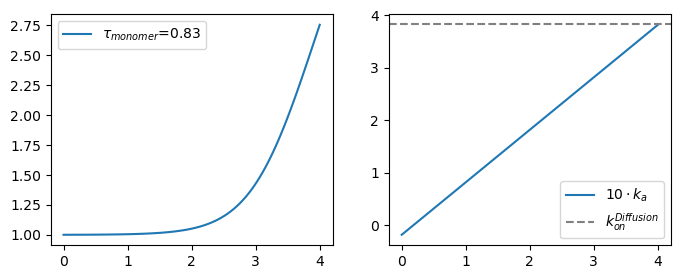

In [12]:
resT = []
for i in range(parms.shape[0]):
    resT.append(ana.ana_resTime_balance(parms.iloc[i], numClusterS=0))
    
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
ax1.plot(np.log10(parms['KPP']*0.6022), resT/min(resT), label='$\\tau_{monomer}$=%.2f'%min(resT))
ax1.legend()
ax2.plot(np.log10(parms['KPP']*0.6022), np.log10(10*parms['kaPP']/area3Dto1D), label='$10\cdot k_a$')
ax2.axhline(np.log10(onRateDiff), color='gray', ls='--', label='$k_{on}^{Diffusion}$')
ax2.legend()

In [13]:
equis = numericSolver(parm_df=parms, labels=labels, model=rxnNetwork)

2024-10-03 15:15:05.492870
Number of cores used:  34/36
Finished parallel processing.


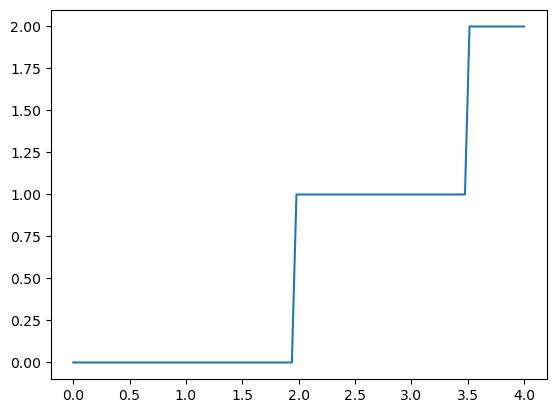

In [14]:
plt.plot(
    np.log10(parms['KPP']*0.6022), 
    np.ceil(np.round(5 - (equis['P']+equis['PN'])*5/1e6, 1))
)

## set input

In [15]:
WaterBox = [21.0*50, 31.623, 31.623]

# SCrds = [-20.0, -11.0]

NCrds = generate_N_crd(12*50, [-WaterBox[0]/2, WaterBox[0]/2])
PCrds = generate_P_crd(
    20, [-WaterBox[0]/2, WaterBox[0]/2],
    y = WaterBox[1]/2, z = WaterBox[2]/2, sigma=2
)

In [16]:
C0 = 0.6022
def onRate_macro2micro(ka_macro, D, sigma):
    if ka_macro < 1e-10:
        return 0
    else:
        return (1/ka_macro - 1/(4*np.pi*D*sigma))**-1

kbPFixed = 0.4

DP3D = 1.5
DN1D = 1.0
PPsigma = 2
DP1D = (1/DP3D + 1/DN1D)**(-1)
konMax = (4*np.pi*(2*DP3D)*PPsigma)
print('DP1D: %.3f\tKonD: %.3f\tKPPmax (M^-1): %.1e'%(DP1D, konMax, konMax/(kbPFixed*1e-6)*C0))
kaPS_macro = 1000 # nm^3/s
kaPN_macro = 200 # nm^3/s
kaPS = onRate_macro2micro(kaPS_macro*1e-6, DP3D, 1)
kaPN = onRate_macro2micro(kaPN_macro*1e-6, DP3D, 1)

Rmax = PPsigma + 3*np.sqrt(6*DP3D*2 * 1 )
if Rmax > WaterBox[0]/2:
    print(f'Diffusion per step too large to stay in waterbox.x: Rmax={Rmax:.1f}, x/2={WaterBox[0]/2:.1f}')
if Rmax > WaterBox[1]/2:
    print(f'Diffusion per step too large to stay in waterbox.y: Rmax={Rmax:.1f}, x/2={WaterBox[1]/2:.1f}')
if Rmax > WaterBox[2]/2:
    print(f'Diffusion per step too large to stay in waterbox.z: Rmax={Rmax:.1f}, x/2={WaterBox[2]/2:.1f}')

DP1D: 0.600	KonD: 75.398	KPPmax (M^-1): 1.1e+08


In [18]:
utils.beforeRun(N=20, L=WaterBox[0], D=DP1D, sigma=2, k=1.66e-4, dimension='1D')
utils.beforeRun(N=20, L=np.prod(WaterBox), D=DP3D, sigma=2, k=1.66e-4, dimension='3D')

Diffusion requires dt < 35.888671875
The maximam association rate is 0.0014470124991122768 when dt = 35.888671875
Diffusion requires dt < 5.566285387670214
The maximam association rate is 2.946405079255439e-06 when dt = 5.566285387670214


In [21]:
C0 = 0.6022
def rlog(x, acc=2):
    if x==0:
        return '-inf'
    else:
        if acc==0:
            return int(np.log10(x))
        else:
            return round(np.log10(x), acc)

equi_parms = [
    [100/C0, 0/C0], #
    [100/C0, 1e2/C0], #
    [100/C0, 1e3/C0], #
    [100/C0, 1e4/C0], #
] # M^-1 -> nm^3

N_repeat = 1
accBind = 1e6 # accelarate binding to relax from bound state
pfolder = './allBound/'

for KPN, KPP in equi_parms:
    kbPN = kaPN*1e6 / KPN
    if KPP == 0:
        kbPP = 0
        kaPP = 0
    else:
        kbPP = kbPFixed
        kaPP = onRate_macro2micro(KPP*kbPP*1e-6, 2*DP3D, PPsigma)
        kbPP = kaPP / KPP * 1e6
    print('kaP: %.2e'%kaPP, 'kbP: %.2e'%kbPP, 'kbN: %.2e'%kbPN)
    nItr = 1e5
    for rn in range(N_repeat):
        if KPP == 0:
            namedir = f'{pfolder}/kpp0kpnE{rlog(KPN*C0,1)}/{rn}/'
        else:
            namedir = f'{pfolder}/kppE{rlog(KPP*C0,1)}kpnE{rlog(KPN*C0,1)}/{rn}/'
        parmFile = f'''# two proteins discover between two segments

start parameters
    nItr = 1e{int(np.log10(nItr))} #iterations
    timeStep = 1 # us, the maximum timestep calculated from kbPN
    timeWrite = 1e6
    pdbWrite = 1e{int(np.log10((nItr/1e1)))}
    trajWrite = 1e{int(np.log10((nItr/1e1)))}
    assocdissocwrite = true
    overlapSepLimit = 1.0
end parameters

start boundaries
    WaterBox = {WaterBox} # VtoL=4000
end boundaries

start molecules
    P : {len(PCrds)}
    N : {len(NCrds)}
end molecules

start reactions

    N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
    onRate3Dka = {kaPN*accBind}
    offRatekb = {kbPN} # Keq = 10^{rlog(KPN*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.00
    assocAngles = [1.289349, 2.579046, 0.000000, nan, M_PI]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10

    P(dmr) + P(dmr) <-> P(dmr!1).P(dmr!1)
    onRate3Dka = {kaPP*accBind} 
    offRatekb = {kbPP} # Keq = 10^{rlog(KPP*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 2.00
    assocAngles = [1.570796, 1.570796, -1.570796, 1.570796, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 10
    area3dto1d = 10

end reactions
'''
        # create directory and write parameters
        Path(namedir).mkdir(parents=True, exist_ok=True)
        with open(f'./{namedir}/parms.inp', 'w') as f:
            f.write(parmFile)
        # write coordinates
        crdFileName = f'./{namedir}/fixCoordinates.inp'
        fixCoords={'P':PCrds, 'N':NCrds, }
        Write_CrdInp(crdFileName, fixCoords, WaterBox)

kaP: 0.00e+00 kbP: 0.00e+00 kbN: 1.20e+00
kaP: 6.64e-05 kbP: 4.00e-01 kbN: 1.20e+00
kaP: 6.64e-04 kbP: 4.00e-01 kbN: 1.20e+00
kaP: 6.64e-03 kbP: 4.00e-01 kbN: 1.20e+00


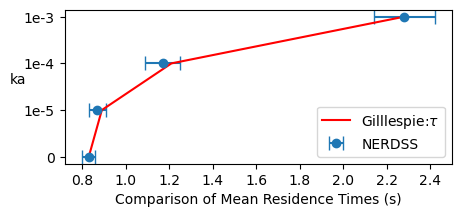

In [17]:
mean_values = np.array([0.83, 0.87, 1.17, 2.28])
std_devs = np.array([0.03, 0.04, 0.08, 0.14])
true_values = np.array([0.83, 0.89, 1.21, 2.28])

plt.figure(figsize=(5,2))

# Indices for the x-axis
x = np.arange(len(mean_values))

# Plot mean values with error bars representing the standard deviation
plt.errorbar(mean_values, x, xerr=std_devs, fmt='o', capsize=5, label='NERDSS')

# Plot true values as a line
plt.plot(true_values, x, 'r-', label='Gilllespie:$\\tau$')

# Add labels and title
plt.ylabel('ka', rotation='horizontal')
plt.yticks(x, [0, '1e-5', '1e-4', '1e-3'])
plt.xlabel('Comparison of Mean Residence Times (s)')
plt.legend()

# Show plot
plt.show()

# Analyze association rates etc.

In [35]:
WaterBox = [32.0, 31.623, 31.623]

nuc = [-WaterBox[0]/2, WaterBox[0]/2, 0] 

SCrds = [-1.0, 1.0] # separated

NCrds = generate_N_crd(10, [-10.5, 10.5])

crdFileName = f'./molFiles/structure/fixCoordinates.inp'
fixCoords={'nuc':nuc,'S':SCrds,  'N':NCrds}
Write_CrdInp(crdFileName, fixCoords, WaterBox)

In [1]:
import numpy as np
from scipy.special import erfc, erfcx
from matplotlib import pyplot as plt
def preact_3D(x0, sigma, D, dt, k):
    '''Calculate 3-D reaction probability from Smoluchovski's theory '''
    z = x0 - sigma
    kD = 4*np.pi*sigma*D
    alpha = np.sqrt(D)/sigma * (1 + k/kD)
    P = sigma/x0*k/(k + kD) * \
        (erfc(z/np.sqrt(4*D*dt)) - np.exp(-z**2/(4*D*dt)) * erfcx(z/np.sqrt(4*D*dt) + alpha*np.sqrt(dt)))
    return P

In [7]:
preact_3D(x0=0.729108, sigma=0.729108, D=40, dt=0.3, k=10)

0.02355160457032345

In [10]:
( 1/(100) - 1/(4*np.pi*0.7291*40) + 1/(4*np.pi*0.7291*30) )**-1

91.66289341583479

In [9]:
( 1/(10) - 1/(4*np.pi*0.7291*40) + 1/(4*np.pi*0.7291*30) )**-1

9.909865808938534

[]

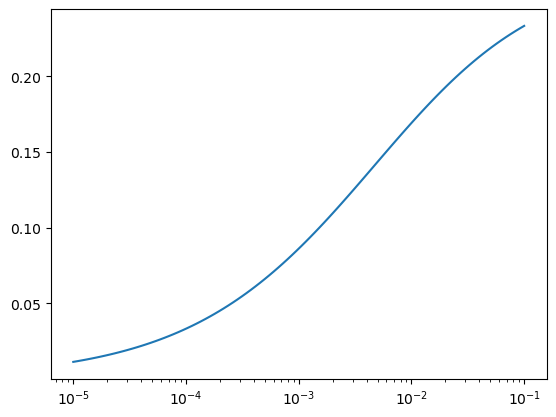

In [29]:
t = np.logspace(-5,-1,100)
plt.plot(t, preact_3D(0.729, 0.729, 40, t, (1/100 - 1/(4*np.pi*0.729*40))**-1))
plt.semilogx()

In [32]:
utils.beforeRun(N=1000, L=321.47**3, D=40, sigma=0.729, k=100, dimension='3D')

Diffusion requires dt < 0.17091087740605757
The maximam association rate is 0.1884922406877396 when dt = 0.17091087740605757


# spaceholder